In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare the data
file_path = 'IBM_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.drop('Name', axis=1)


In [46]:
# Identify missing days 
all_days = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

missing_days = all_days.difference(data.index)

missing_days_df = pd.DataFrame(missing_days, columns=['MissingDate'])
missing_days_df['DayOfWeek'] = missing_days_df['MissingDate'].dt.day_name()

print("Missing days with day of the week:")
print(missing_days_df)

pattern_analysis = missing_days_df['DayOfWeek'].value_counts()
print("\nPattern of missing days by day of the week:")
print(pattern_analysis)

Missing days with day of the week:
     MissingDate DayOfWeek
0     2006-01-07  Saturday
1     2006-01-08    Sunday
2     2006-01-14  Saturday
3     2006-01-15    Sunday
4     2006-01-16    Monday
...          ...       ...
1354  2017-12-16  Saturday
1355  2017-12-17    Sunday
1356  2017-12-23  Saturday
1357  2017-12-24    Sunday
1358  2017-12-25    Monday

[1359 rows x 2 columns]

Pattern of missing days by day of the week:
DayOfWeek
Saturday     625
Sunday       625
Monday        59
Friday        21
Thursday      17
Tuesday        8
Wednesday      4
Name: count, dtype: int64


In [47]:
# NaN values
data[data.isna().any(axis=1)]

,Open,High,Low,Close,Volume
Date,,,,,
2017-07-31,NaN,144.93,NaN,144.67,4355718


In [48]:
# cleanup
data_resampled = data.asfreq('D')
data_resampled = data_resampled.interpolate(method='time')

# Transformer

In [49]:
# Resample and interpolate missing values
data_resampled = data.asfreq('D')
data_resampled = data_resampled.interpolate(method='time')

# Use only the 'Close' column for this example
close_prices = data_resampled['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
close_prices_scaled = scaler.fit_transform(close_prices)

In [ ]:
# Prepare the dataset for Transformer
T = 7  # Time lag 
X, Y = [], []
for t in range(len(close_prices_scaled) - T):
    X.append(close_prices_scaled[t:t + T])
    Y.append(close_prices_scaled[t + T])

X = np.array(X)
Y = np.array(Y)

# Split into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

# Reshape for Transformer (batch_size, seq_len, feature_dim)
X_train = X_train.reshape(-1, T, 1)
X_test = X_test.reshape(-1, T, 1)

In [51]:
# Define Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):

    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


In [53]:
# Build Transformer Model
def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0):
    n_timesteps, n_features, n_outputs = T, 1, 1
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)

transformer = build_transformer(head_size=128, num_heads=4, ff_dim=64, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10)

# Compile and train the Transformer
def fit_transformer(transformer, X_train, Y_train):

    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", "mape"]
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    history = transformer.fit(X_train, 
                              Y_train, 
                              batch_size=32,
                              epochs=50, 
                              verbose=1, 
                              callbacks=callbacks)
    return history

history = fit_transformer(transformer, X_train, Y_train)

# Predict on the test set
Y_pred_scaled = transformer.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")


Epoch 1/50
110/110 [==============================] - 15s 36ms/step - loss: 0.0074 - mae: 0.0543 - mape: 9740.5205
Epoch 2/50
110/110 [==============================] - 5s 48ms/step - loss: 0.0015 - mae: 0.0281 - mape: 11975.9375
Epoch 3/50
110/110 [==============================] - 9s 86ms/step - loss: 0.0013 - mae: 0.0267 - mape: 15808.6475
Epoch 4/50
110/110 [==============================] - 10s 90ms/step - loss: 0.0012 - mae: 0.0250 - mape: 19436.7227
Epoch 5/50
110/110 [==============================] - 4s 35ms/step - loss: 9.6949e-04 - mae: 0.0229 - mape: 18257.3828
Epoch 6/50
110/110 [==============================] - 4s 38ms/step - loss: 8.5187e-04 - mae: 0.0213 - mape: 10720.5859
Epoch 7/50
110/110 [==============================] - 5s 44ms/step - loss: 8.1602e-04 - mae: 0.0212 - mape: 15294.8438
Epoch 8/50
110/110 [==============================] - 10s 88ms/step - loss: 7.3610e-04 - mae: 0.0201 - mape: 13100.8164
Epoch 9/50
110/110 [==============================] - 13s 117m

Mean Squared Error (MSE): 2.1319
Mean Absolute Error (MAE): 13.7598
Mean Absolute Percentage Error (MAPE): 9.10%


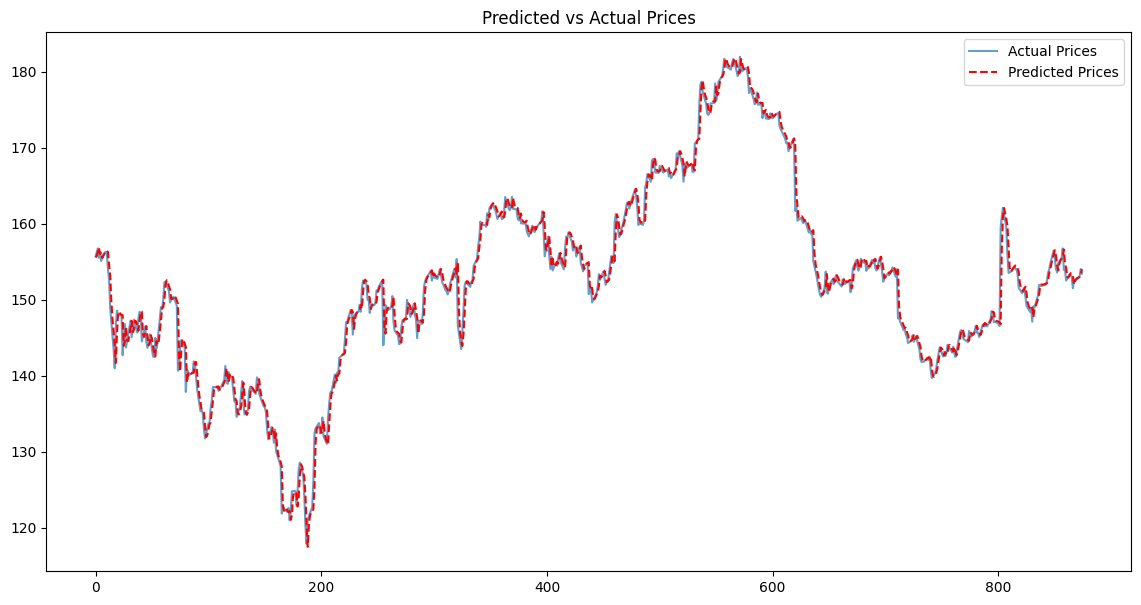

In [54]:
# Calculate metrics
mse = mean_squared_error(Y_test_rescaled, Y_pred)
mae = np.mean(np.abs(Y_test_rescaled - Y_pred))
mape = np.mean(np.abs((Y_test_rescaled - Y_pred) / Y_test_rescaled)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(Y_test, label="Actual Prices", alpha=0.7)
plt.plot(Y_pred, label="Predicted Prices", linestyle="--", color="red")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()

In [55]:
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 7, 1)]               0         []                            
                                                                                                  
 multi_head_attention_14 (M  (None, 7, 1)                 7169      ['input_10[0][0]',            
 ultiHeadAttention)                                                  'input_10[0][0]']            
                                                                                                  
 dropout_30 (Dropout)        (None, 7, 1)                 0         ['multi_head_attention_14[0][0
                                                                    ]']                           
                                                                                            